In [1]:
import pandas as pd

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/balance-scale/balance-scale.data'

column_names = ['Clase', 'Peso_Izquierdo', 'Distancia_Izquierda', 'Peso_Derecho', 'Distancia_Derecha']
df = pd.read_csv(url, names=column_names)

df.head()

,Clase,Peso_Izquierdo,Distancia_Izquierda,Peso_Derecho,Distancia_Derecha
0,B,1,1,1,1
1,R,1,1,1,2
2,R,1,1,1,3
3,R,1,1,1,4
4,R,1,1,1,5


In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
y = df['Clase']
X = df.drop('Clase', axis=1)

In [4]:
#dividir - entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar
print("Tamaño del set de entrenamiento:", X_train.shape)
print("Tamaño del set de prueba:", X_test.shape)

Tamaño del set de entrenamiento: (500, 4)
Tamaño del set de prueba: (125, 4)


In [5]:
#escalar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Definir el modelo base
svm = SVC()

# Definir los hiperparámetros que se van a probar
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4]
}

# Buscar la mejor combinación de hiperparámetros con validación cruzada
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Usar el mejor modelo encontrado
best_svm = grid_search.best_estimator_

# Predecir en el conjunto de prueba
y_pred = best_svm.predict(X_test_scaled)

In [7]:
# Calcular métricas
accuracySVM = accuracy_score(y_test, y_pred)
precisionSVM = precision_score(y_test, y_pred, average='macro')
recallSVM = recall_score(y_test, y_pred, average='macro')
f1SVM = f1_score(y_test, y_pred, average='macro')

# Mostrar resultados
print("Mejor combinación de hiperparámetros:", grid_search.best_params_)
print("Accuracy:", accuracySVM)
print("Precision:", precisionSVM)
print("Recall:", recallSVM)
print("F1 Score:", f1SVM)

Mejor combinación de hiperparámetros: {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.928
Precision: 0.8378091257401602
Recall: 0.8505392912172572
F1 Score: 0.8431718002200577


In [8]:
# Binarizar las clases (para calcular AUC en multiclase)
classes = best_svm.classes_  # ['B', 'L', 'R']
y_test_bin = label_binarize(y_test, classes=classes)
y_probs = best_svm.decision_function(X_test_scaled)  # devuelve una matriz (n_samples, n_classes)

In [9]:
# Calcular AUC macro promedio
auc = roc_auc_score(y_test_bin, y_probs, average='macro', multi_class='ovr')

print(f"Accuracy: {accuracySVM}")
print(f"Precision: {precisionSVM}")
print(f"Recall: {recallSVM}")
print(f"F1 Score: {f1SVM}")
print(f"AUC (macro): {auc:.4f}")

Accuracy: 0.928
Precision: 0.8378091257401602
Recall: 0.8505392912172572
F1 Score: 0.8431718002200577
AUC (macro): 0.9060


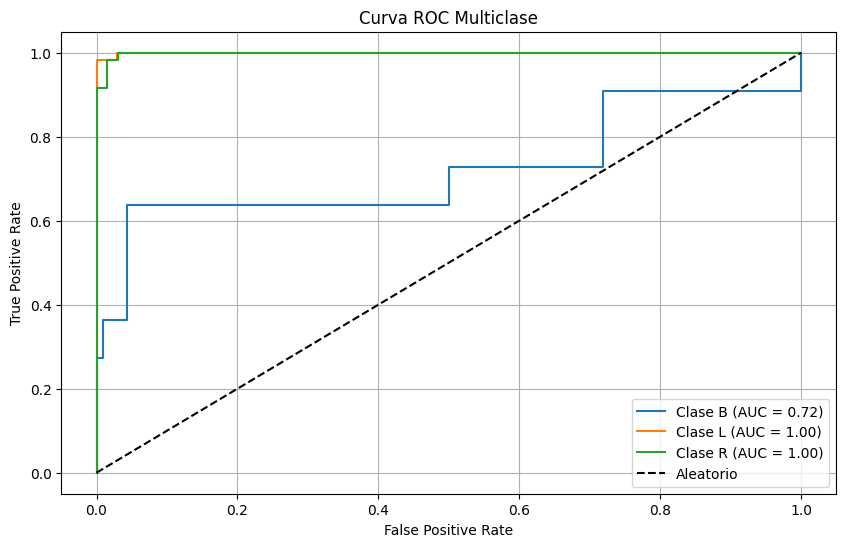

In [10]:
# Curvas ROC para cada clase
plt.figure(figsize=(10, 6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f'Clase {class_label} (AUC = {roc_auc_score(y_test_bin[:, i], y_probs[:, i]):.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Multiclase')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [11]:
# Diccionario para guardar los resultados
resultados_modelos = {}

# Modelos a evaluar
modelos = {
    'SVM': SVC(probability=True, decision_function_shape='ovr', random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42)
}

In [12]:
# Evaluar cada modelo
for nombre, modelo in modelos.items():
    modelo.fit(X_train_scaled, y_train)
    y_pred = modelo.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    resultados_modelos[nombre] = {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'modelo': modelo
    }

    print(f"--- {nombre} ---")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--- SVM ---
Accuracy:  0.9040
Precision: 0.6034
Recall:    0.6610
F1 Score:  0.6303

--- Random Forest ---
Accuracy:  0.8000
Precision: 0.5727
Recall:    0.5863
F1 Score:  0.5770

--- Decision Tree ---
Accuracy:  0.7680
Precision: 0.5690
Recall:    0.5625
F1 Score:  0.5639

--- Extra Trees ---
Accuracy:  0.8000
Precision: 0.5749
Recall:    0.5855
F1 Score:  0.5798



In [13]:
# Elegir el mejor modelo según F1 Score
best_model_final = max(resultados_modelos, key=lambda m: resultados_modelos[m]['f1_score'])
best_model = resultados_modelos[best_model_final]['modelo']
print(f"✅ El mejor modelo según F1 Score es: {best_model_final}")

✅ El mejor modelo según F1 Score es: SVM


In [14]:
# Calcular AUC y Curva ROC para el mejor modelo
# Nota: usamos `decision_function` si es SVM, si no, usamos `predict_proba`
if hasattr(best_model, "decision_function"):
    y_scores = best_model.decision_function(X_test_scaled)
else:
    y_scores = best_model.predict_proba(X_test_scaled)



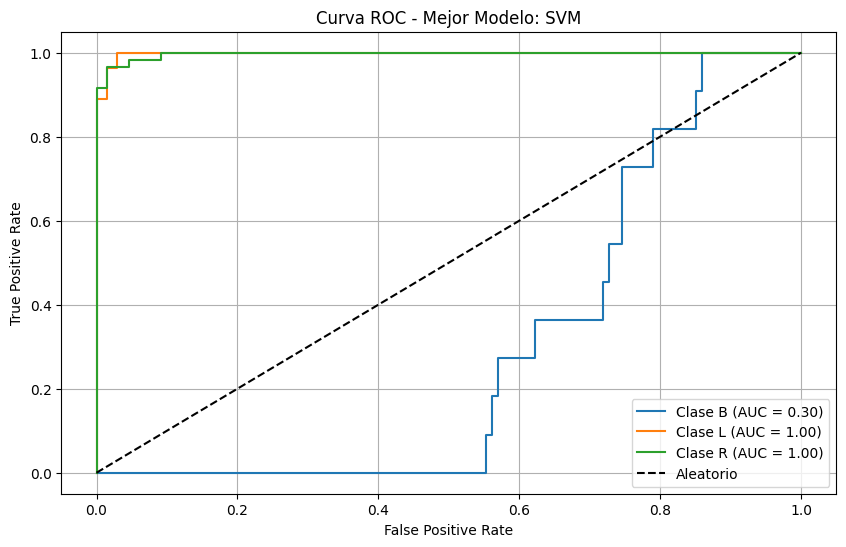

AUC Macro del mejor modelo (SVM): 0.7636


In [15]:
# Calcular AUC (macro) y curvas ROC por clase
auc = roc_auc_score(y_test_bin, y_scores, average='macro', multi_class='ovr')

plt.figure(figsize=(10, 6))
for i, clase in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    auc_clase = roc_auc_score(y_test_bin[:, i], y_scores[:, i])
    plt.plot(fpr, tpr, label=f'Clase {clase} (AUC = {auc_clase:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Curva ROC - Mejor Modelo: {best_model_final}')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f"AUC Macro del mejor modelo ({best_model_final}): {auc:.4f}")

In [16]:
# Comparar Modelos

Accuracy: 0.8080
Precision: 0.6427
Recall: 0.6417
F1 Score: 0.6394
AUC (macro): 0.7740


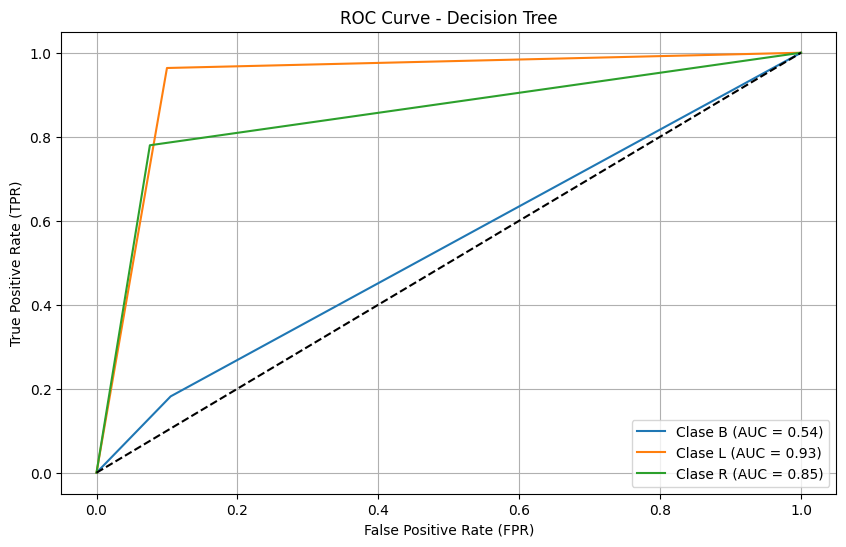

In [17]:
# DecissionTreeClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# PCA: reducir dimensionalidad (opcional pero usado en el ejemplo original)
pca = PCA(n_components=X_train_scaled.shape[1])  # misma cantidad de features
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Clasificador y grid search
dt_classifier = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(dt_classifier, param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)

# Mejor modelo
best_dt = grid_search.best_estimator_
y_pred = best_dt.predict(X_test_pca)

# Métricas
accuracyDT = accuracy_score(y_test, y_pred)
precisionDT = precision_score(y_test, y_pred, average='macro')
recallDT = recall_score(y_test, y_pred, average='macro')
f1DT = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracyDT:.4f}")
print(f"Precision: {precisionDT:.4f}")
print(f"Recall: {recallDT:.4f}")
print(f"F1 Score: {f1DT:.4f}")

# Curva ROC y AUC multiclase (usando predict_proba)
from sklearn.preprocessing import label_binarize
classes = ['B', 'L', 'R']
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_dt.predict_proba(X_test_pca)

# AUC macro
roc_auc = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')
print(f"AUC (macro): {roc_auc:.4f}")

# Curva ROC por clase
plt.figure(figsize=(10, 6))
for i, clase in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    auc_clase = roc_auc_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f'Clase {clase} (AUC = {auc_clase:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Decision Tree')
plt.legend()
plt.grid()
plt.show()

Accuracy: 0.8560
Precision: 0.5722
Recall: 0.6267
F1 Score: 0.5970
AUC (macro): 0.8624


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


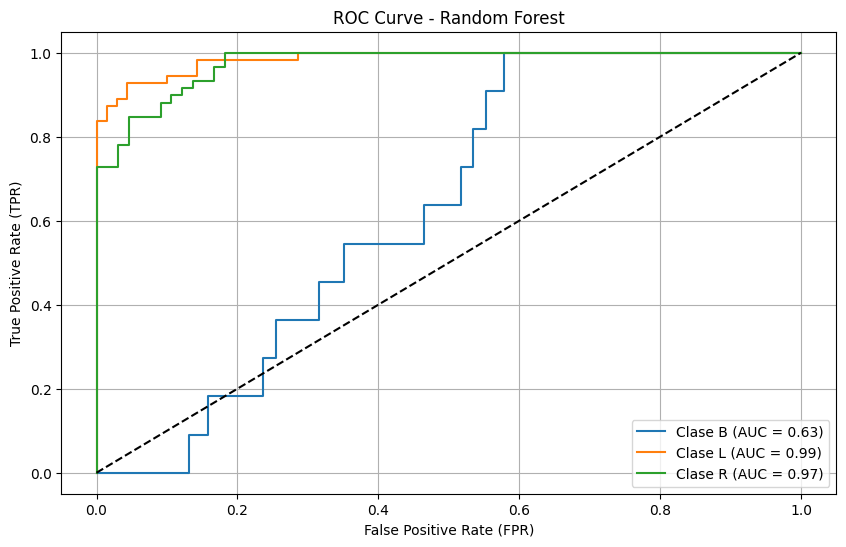

In [18]:
# RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Random Forest con búsqueda de hiperparámetros
rf_classifier = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

best_rf_classifier = grid_search.best_estimator_
y_pred = best_rf_classifier.predict(X_test_scaled)

# Métricas
accuracyRF = accuracy_score(y_test, y_pred)
precisionRF = precision_score(y_test, y_pred, average='macro')
recallRF = recall_score(y_test, y_pred, average='macro')
f1RF = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracyRF:.4f}")
print(f"Precision: {precisionRF:.4f}")
print(f"Recall: {recallRF:.4f}")
print(f"F1 Score: {f1RF:.4f}")

# AUC y curva ROC multiclase
classes = ['B', 'L', 'R']
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_rf_classifier.predict_proba(X_test_scaled)

roc_auc = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')
print(f"AUC (macro): {roc_auc:.4f}")

# Curva ROC por clase
plt.figure(figsize=(10, 6))
for i, clase in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    auc_clase = roc_auc_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f'Clase {clase} (AUC = {auc_clase:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.grid()
plt.show()

Accuracy: 0.8960
Precision: 0.5975
Recall: 0.6554
F1 Score: 0.6248
AUC (macro): 0.8425


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


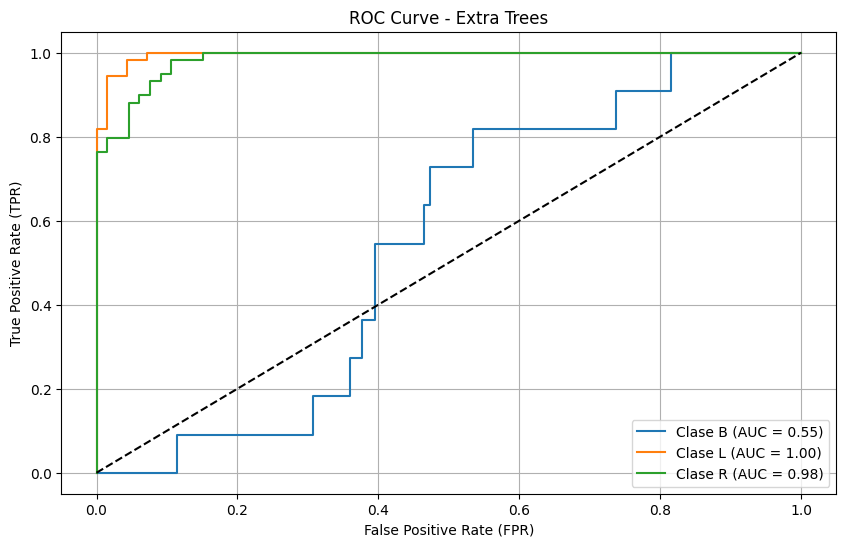

In [19]:
# ExtraTreesClassifier

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Entrenamiento con ExtraTreesClassifier
et_classifier = ExtraTreesClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(et_classifier, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

best_et_classifier = grid_search.best_estimator_
y_pred = best_et_classifier.predict(X_test_scaled)

# Métricas de evaluación
accuracyETC = accuracy_score(y_test, y_pred)
precisionETC = precision_score(y_test, y_pred, average='macro')
recallETC = recall_score(y_test, y_pred, average='macro')
f1ETC = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracyETC:.4f}")
print(f"Precision: {precisionETC:.4f}")
print(f"Recall: {recallETC:.4f}")
print(f"F1 Score: {f1ETC:.4f}")

# AUC y curva ROC multiclase
classes = ['B', 'L', 'R']
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_et_classifier.predict_proba(X_test_scaled)

roc_auc = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')
print(f"AUC (macro): {roc_auc:.4f}")

# Curva ROC por clase
plt.figure(figsize=(10, 6))
for i, clase in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    auc_clase = roc_auc_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f'Clase {clase} (AUC = {auc_clase:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Extra Trees')
plt.legend()
plt.grid()
plt.show()

In [20]:
# Crear diccionario con los modelos y sus F1 Scores
modelos = {
    "SVM": (best_svm, f1SVM),
    "Decision Tree": (best_dt, f1DT),
    "Random Forest": (best_rf_classifier, f1RF),
    "Extra Trees": (best_et_classifier, f1ETC)
}

# Elegir el modelo con mayor F1 Score
mejor_modelo_nombre = max(modelos, key=lambda x: modelos[x][1])
mejor_modelo = modelos[mejor_modelo_nombre][0]

print(f"➡️ Mejor modelo según F1 Score: {mejor_modelo_nombre} (F1 = {modelos[mejor_modelo_nombre][1]:.4f})")

# Usar el mejor modelo para hacer predicciones
if mejor_modelo_nombre == "SVM":
    X_final = X_test_scaled
elif mejor_modelo_nombre in ["Decision Tree", "Extra Trees"]:
    X_final = X_test_pca
else:
    X_final = X_test  # Random Forest usa datos sin PCA ni escalado

final_predictions = mejor_modelo.predict(X_final)

print("Primera fila del set de prueba transformado:")
print(X_final[0])
print("Tipo de datos:", type(X_final))

➡️ Mejor modelo según F1 Score: SVM (F1 = 0.8432)
Primera fila del set de prueba transformado:
[ 0.70251646 -0.00422791  1.37086814 -0.03147627]
Tipo de datos: <class 'numpy.ndarray'>


In [21]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_val_score
from scipy import stats
import numpy as np

# Validación cruzada sobre el mejor modelo
scores = cross_val_score(mejor_modelo, X_test_scaled, y_test, scoring='f1', cv=5)

confidence = 0.95
mean_score = scores.mean()
sem_score = stats.sem(scores)
interval = stats.t.interval(confidence, len(scores) - 1, loc=mean_score, scale=sem_score)

print(f"F1 Score promedio: {mean_score:.4f}")
print(f"Intervalo de confianza al {int(confidence * 100)}%: {interval}")


F1 Score promedio: nan
Intervalo de confianza al 95%: (np.float64(nan), np.float64(nan))


In [22]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [25]:
# import joblib

# Guardar el modelo final (SVM)
# joblib.dump(best_svm, "final_model.pkl", compress=3)

# Guardar el escalador
# joblib.dump(scaler, "scaler.pkl", compress=3)

# Guardar el PCA
# joblib.dump(pca, "pca.pkl", compress=3)

# Guardar el codificador de clases
# joblib.dump(label_encoder, "label_encoder.pkl", compress=3)

In [26]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
import joblib

# Definir la variable 'y' (etiquetas) y 'X' (características)
y = df['Clase']
X = df.drop('Clase', axis=1)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar la distribución de clases en el set de entrenamiento
print("Distribución de clases en el set de entrenamiento:")
print(y_train.value_counts())

# Aplicar el LabelEncoder a las etiquetas
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Codificar las etiquetas del conjunto de entrenamiento
y_test_encoded = label_encoder.transform(y_test)  # Codificar las etiquetas del conjunto de prueba

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir el modelo base
svm = SVC(probability=True)  # Es importante tener probability=True para usar predict_proba

# Definir los hiperparámetros a probar
param_grid = {
    'C': [0.1, 1, 10, 100],  # Penalización
    'gamma': ['scale', 'auto'],  # Diferentes valores para gamma
    'kernel': ['linear', 'rbf', 'poly'],  # Diferentes tipos de kernel
    'degree': [2, 3, 4]  # Solo si se usa 'poly', el grado del polinomio
}

# Buscar la mejor combinación de hiperparámetros con validación cruzada
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train_encoded)

# Obtener el mejor modelo
best_svm = grid_search.best_estimator_

# Predecir en el conjunto de prueba
y_pred = best_svm.predict(X_test_scaled)

# Evaluar el modelo
from sklearn.metrics import accuracy_score, f1_score
print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print("F1 Score:", f1_score(y_test_encoded, y_pred, average='macro'))

# Guardar el modelo y los objetos necesarios para usar en Streamlit
joblib.dump(best_svm, "final_model.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")
joblib.dump(scaler, "scaler.pkl")


Distribución de clases en el set de entrenamiento:
Clase
L    233
R    229
B     38
Name: count, dtype: int64
Accuracy: 0.928
F1 Score: 0.8431718002200577


['scaler.pkl']